# SAMPLE INFORMATION

This script holds the initial preprocessing steps for all of the datasets we will be working with. Here is a breif overview of the data we're analyzing. 

1. Townsend et al. (FCD tissue) 10X


Sample prep: frozen resected brain tissue for snRNAseq


JLE48_3: 6 month, M, Type II FCD, Temporal Lobe 


JLE49_3: 4 yrs, M, Type I FCD, Anterior, Superior, and Frontal Gyrus


JLE50_3: 2 yrs, F, Type III FCD, Left inferior and Frontal Gyrus



2. Westfall et al. (FCD and control tissue)


Sample prep: frozen tissue for snRNAseq 10X


JLE18: 11-15 yrs, F, Type I FCD, Superior parietal and occipital lobe


JLE33: 11-15 yrs, F, Type I FCD, Middle frontal gyrus


NB1499: 0-5 yrs, F, Temporal cortex (Broadmann area 22)


NB4327: 0-5 yrs, F, Temporal cortex (Broadmann area 22)



In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

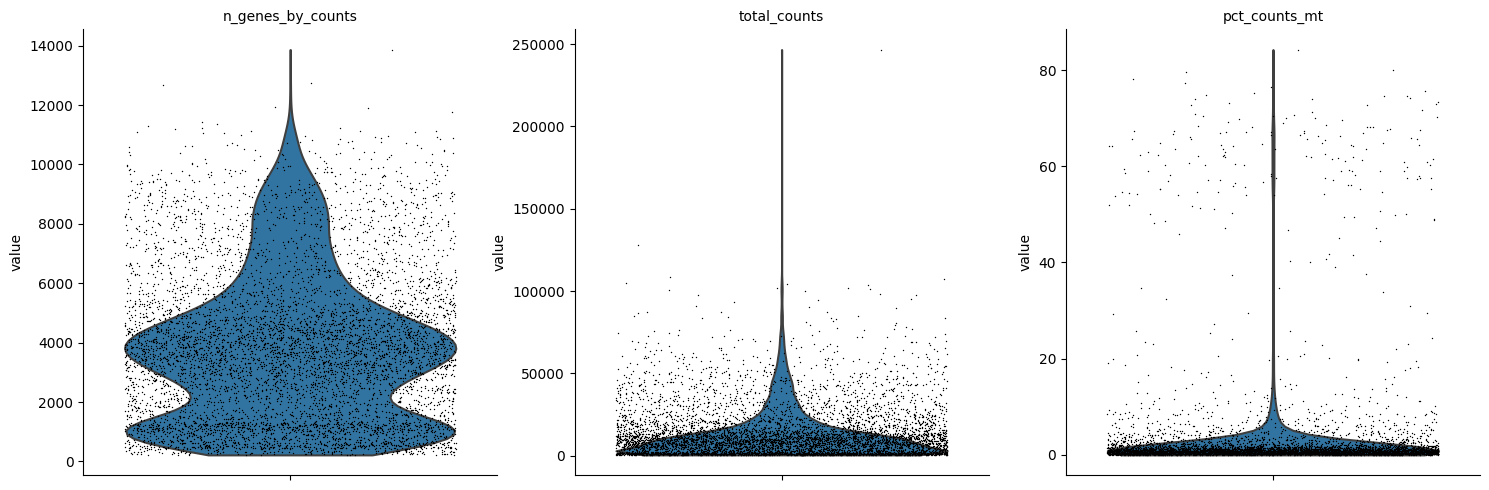

In [3]:
# normal setup
path = 'Townsend_JLE49_3'

# To initialize the AnnData object with the RNA data.
data = sc.read_10x_mtx(path, gex_only=True)

# Just to match the Seurat filtering (only including genes that are in at least 3 cells; and only including cells that have at least 200 genes), we'll say:
sc.pp.filter_cells(data, min_genes=200)
sc.pp.filter_genes(data, min_cells=3)
data

# We calculate mitochondrial QC metrics with the calculate_qc_metrics() function, which calculates the percentage of 
# counts originating from a set of features
# We use the set of all genes starting with MT- as a set of mitochondrial genes
data.var['mt'] = data.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(data, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# Visualize QC metrics as a violin plot
sc.pl.violin(data, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [4]:
# Remove cells that have too many mitochondrial genes expressed or too many gene counts
print(len(data))
data = data[data.obs.n_genes_by_counts > 200,] # keep cells with only more than 200 genes
data = data[data.obs.pct_counts_mt < 10,] # keep cells with only less than 10% mito genes as these are "normal"
print(len(data))

6729
6441


/usr/local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


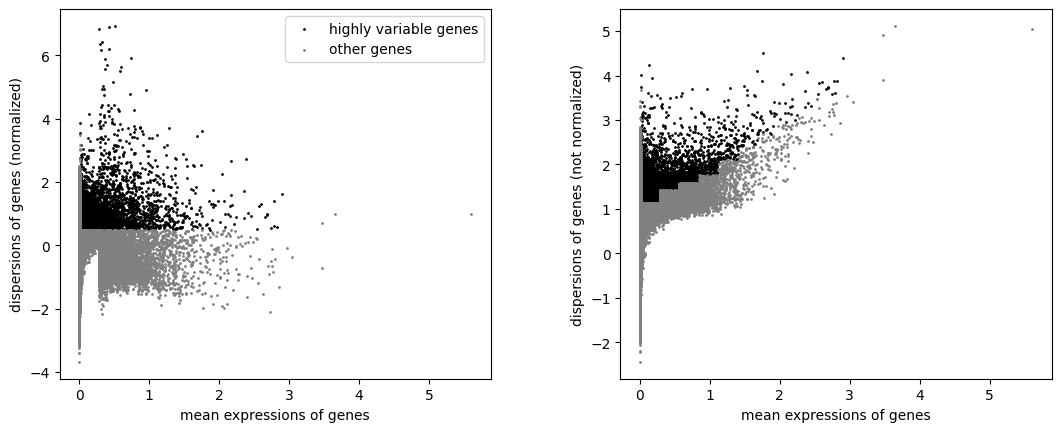

In [5]:
# normalize
sc.pp.normalize_total(data)
sc.pp.log1p(data)

# save log(CPM+1) data as "raw"
data.raw = data  

# identify variable genes
sc.pp.highly_variable_genes(data)

# view top 10
data.var.loc[data.var.highly_variable].sort_values("dispersions", ascending=False).head(10)

# plot variablility distribution
sc.pl.highly_variable_genes(data)

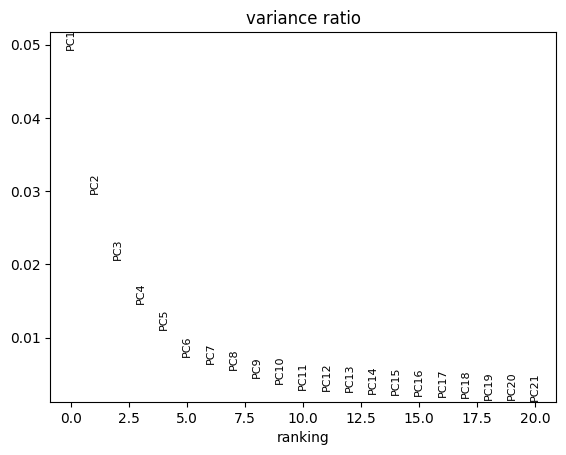

In [6]:
# PCA 

# Z-score scale. Clip values exceeding standard deviation 10.
sc.pp.scale(data, max_value=10)

# PCA, default subsets to highly variable features
sc.tl.pca(data)

# A visualization that is useful for determining how many PCs to include
sc.pl.pca_variance_ratio(data, n_pcs=20)

In [7]:
# computing the neighborhood graph and find clusters
sc.pp.neighbors(data, n_pcs=15)
sc.tl.leiden(data, resolution=0.2)

/usr/local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


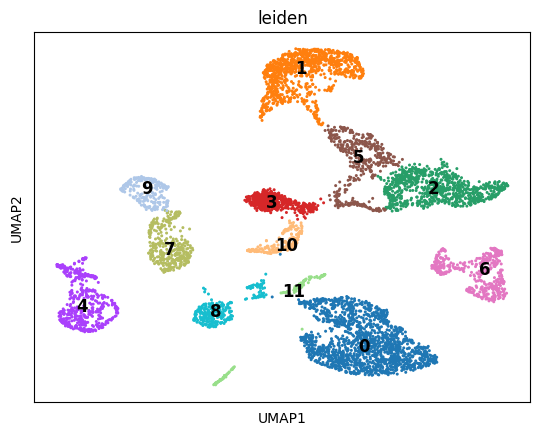

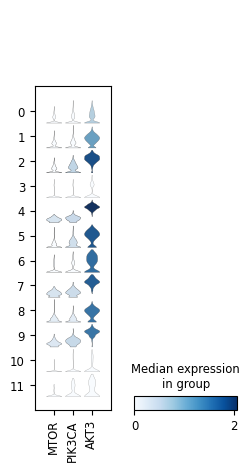

/usr/local/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


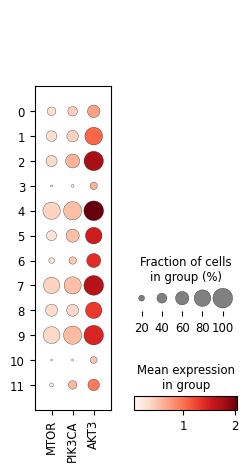

"sc.pl.rank_genes_groups_dotplot(data, groupby='leiden', n_genes=5) # top-ranked DE genes between groups of cells\nsc.pl.umap(data, color=['PTPRC', 'AIF1'], size=20) # plot specific genes you want on umap"

In [8]:
# run UMAP
sc.tl.umap(data)

# plot UMAP
fig = sc.pl.umap(data, color=['leiden'],
                legend_fontsize = 12,
                legend_loc = 'on data')

# WHAT YOU CAN DO WITH UMAP

#1. color cells with different metadata annotations or clustering results
# what meta data is in my DataAnn object
"""print(data.obs.columns)
sc.pl.umap(data, color = ['n_genes'])
sc.pl.umap(data, color = ['n_genes_by_counts'])
sc.pl.umap(data, color = ['total_counts'])
sc.pl.umap(data, color = ['total_counts_mt'])
sc.pl.umap(data, color = ['pct_counts_mt'])
sc.pl.umap(data, color = ['leiden'])"""

#2. identify cell types and subpopulaitons based on marker gene expression
sc.pl.stacked_violin(data, var_names=['MTOR', 'PIK3CA', 'AKT3'], groupby='leiden')
sc.pl.dotplot(data, var_names=['MTOR', 'PIK3CA', 'AKT3'], groupby='leiden')

#3. investigate relationships between cell types or subpopulaiton on UMAP plot
"""sc.pl.rank_genes_groups_dotplot(data, groupby='leiden', n_genes=5) # top-ranked DE genes between groups of cells
sc.pl.umap(data, color=['PTPRC', 'AIF1'], size=20) # plot specific genes you want on umap"""

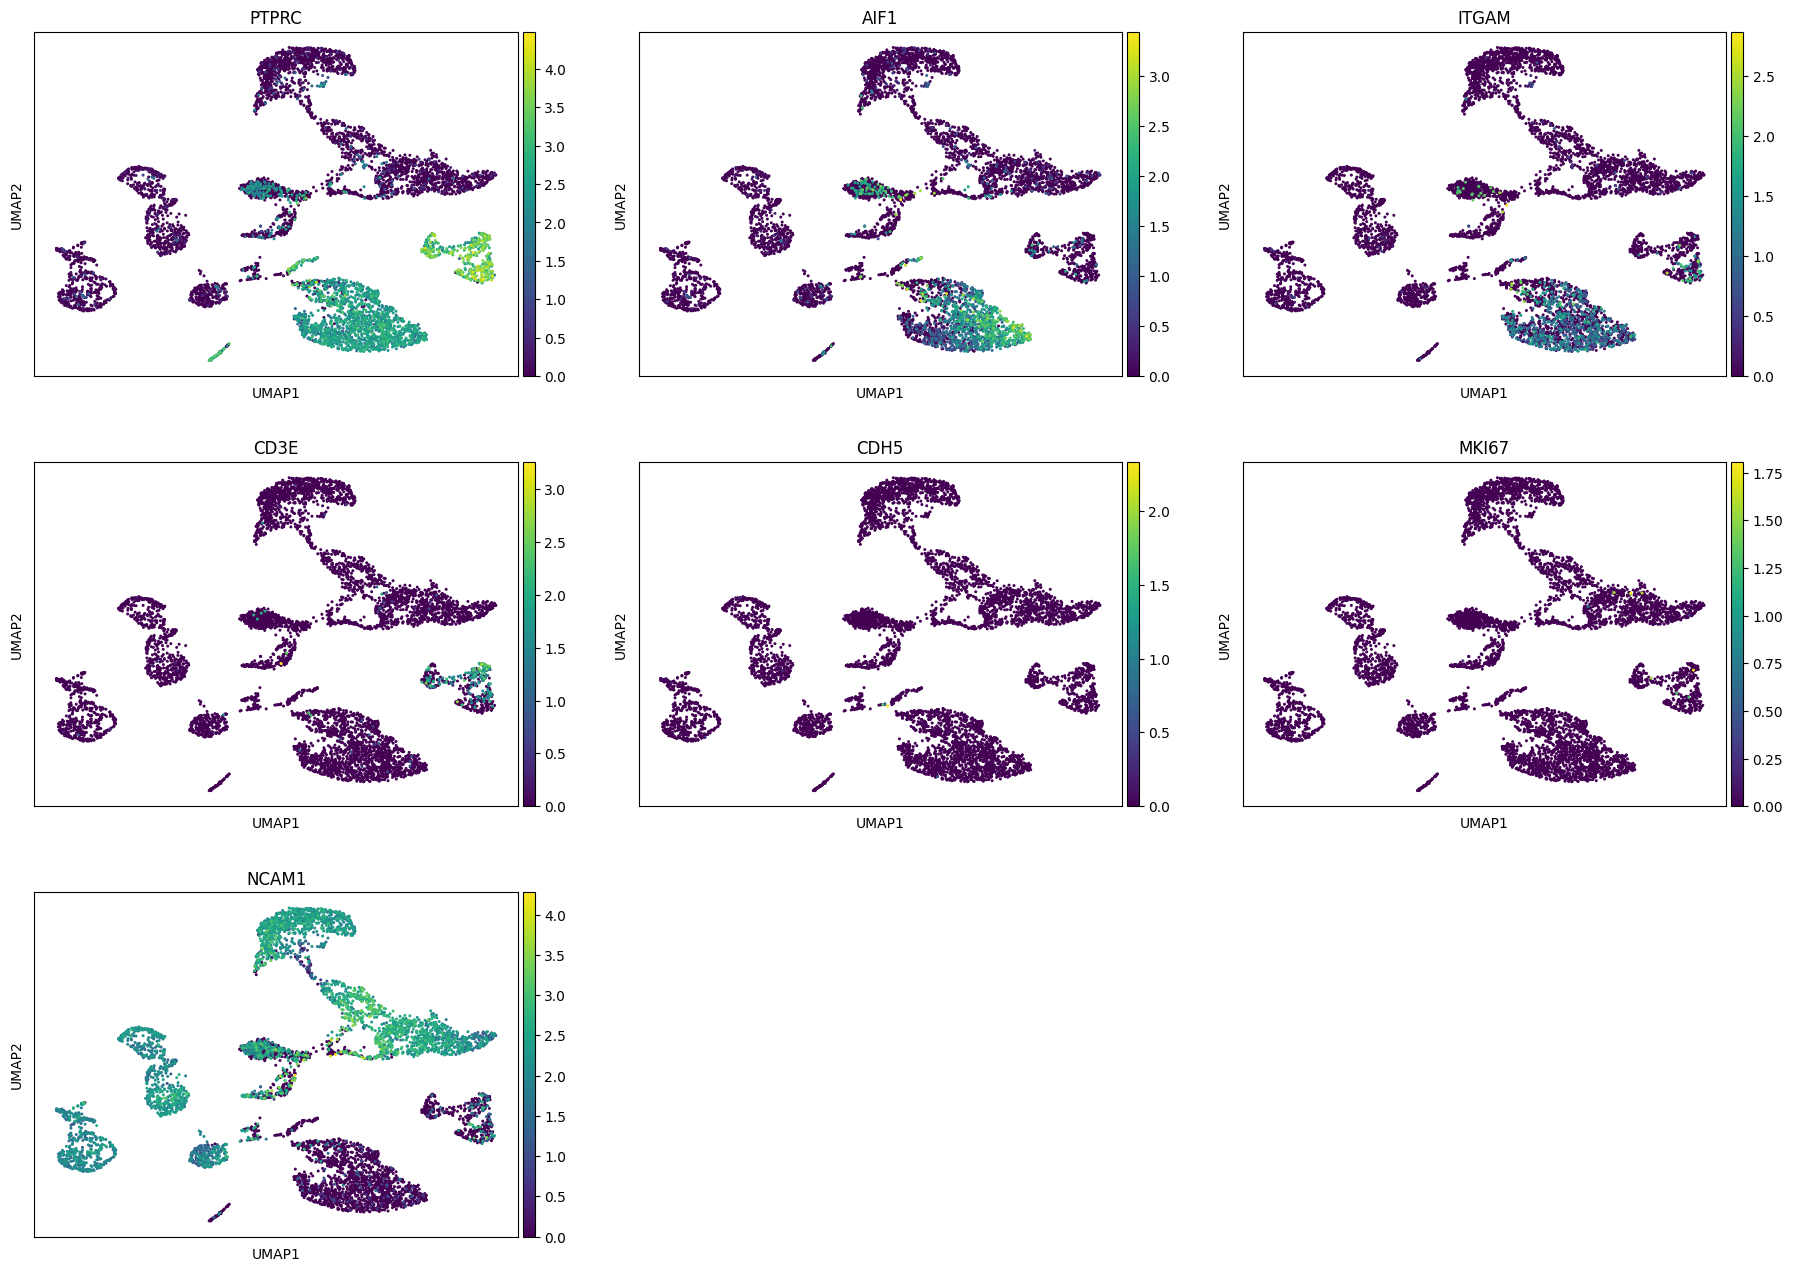

In [ ]:
# Plot of lineage markers
genes_to_plot = ['PTPRC', 'AIF1', 'ITGAM', 'CD3E', 'CDH5', 'MKI67', 'NCAM1']

"""
What are these lineaged markers?

PTPRC - CD45, so immune cells like T cells, B cells, and macrophages (surface)
AIF1 - macrophages and microglia (protein)
ITGAM - CD11b, macrophages, dendritic cells, monocytes (surface)
CD3E - T cells, activation of T cell signaling 
CDH5 - endothelian cells, cell adhesion and blood vessel formation 
MKI67 - protein expressed during active cell proliferation 
NCAM1 - CD56, Natural killer cells and T-cells subset

"""

sc.pl.umap(data, color=genes_to_plot, use_raw=True,
                sort_order=True, ncols=3)

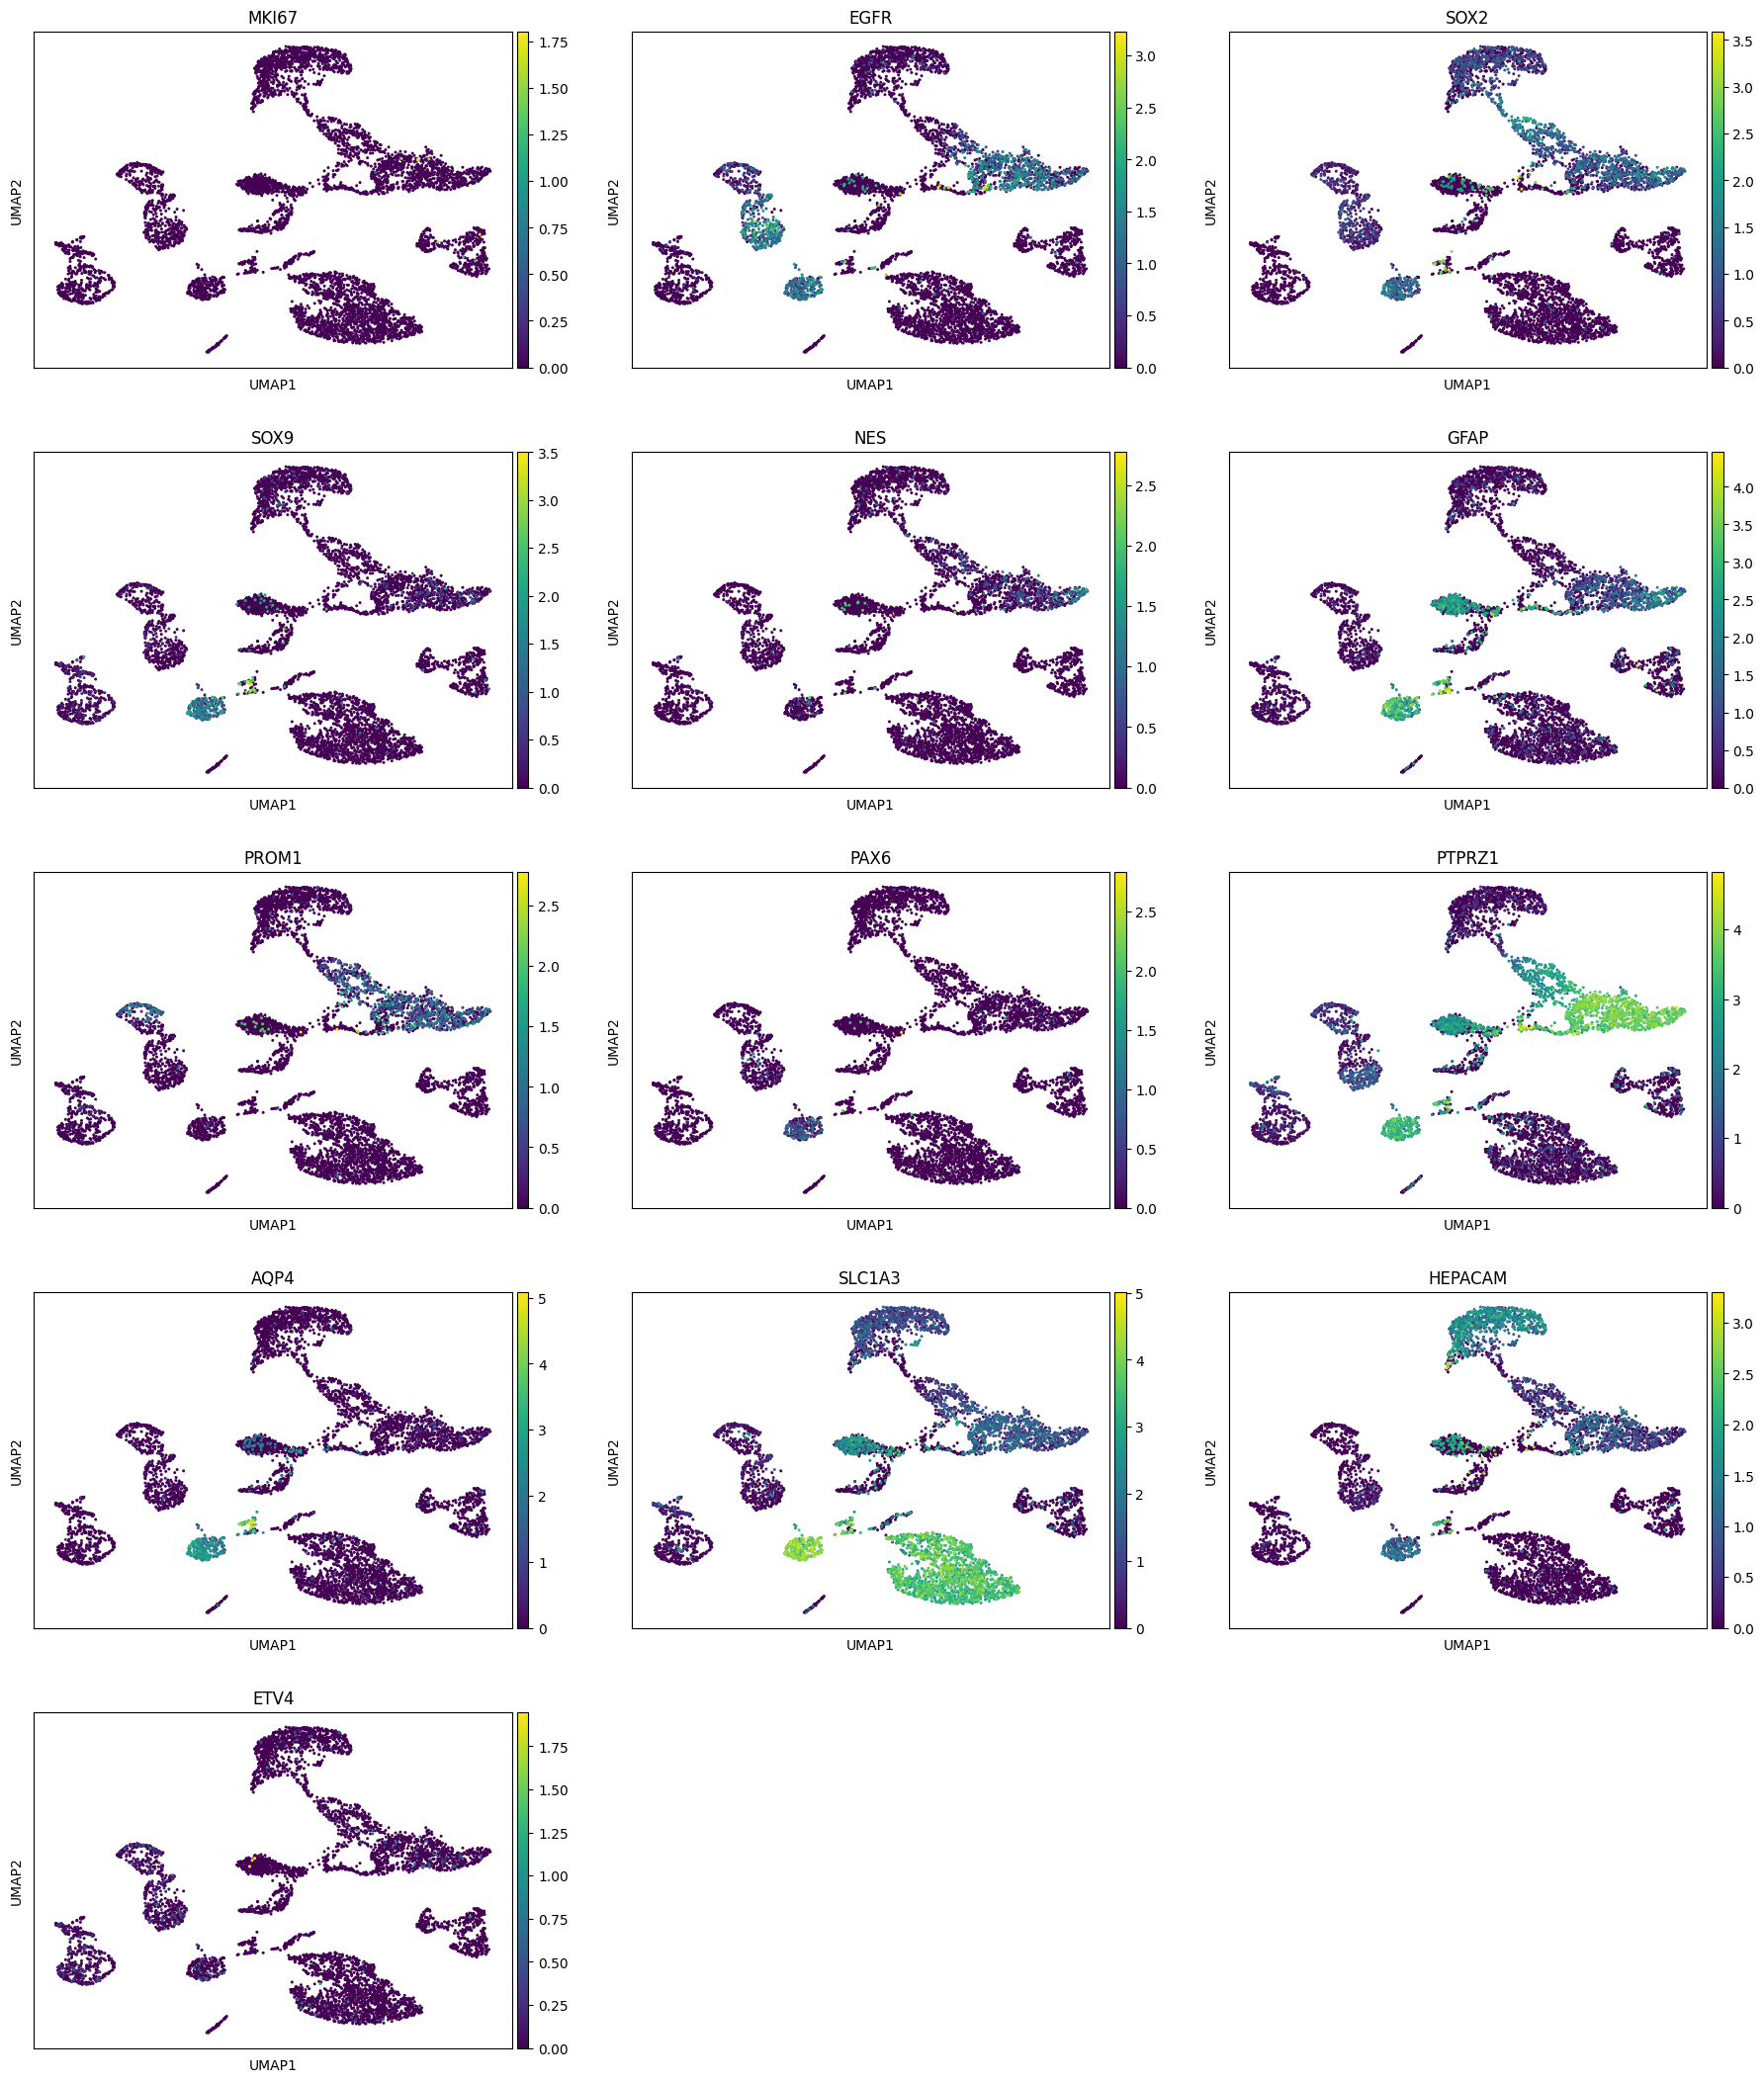

In [11]:
# Plot of Neural Stem Cells/Astrocytes markers
genes_to_plot = ['MKI67', 'EGFR', 'SOX2', 'SOX9', 'NES', 'GFAP', 'PROM1', 'PAX6', 'PTPRZ1',
                                   'AQP4', 'SLC1A3', 'HEPACAM', 'ETV4']

"""
What are these NSC markers?

MKI67 - protein expressed during active cell proliferation, actively dividing cells, NSCs and progenitors
EGFR - cell proliferation/survival, marker for NSC + progenitors
SOX2 - TF important for self renewal and pluripotency of NSCs
SOX9 - TF important for differentiation of NSCs into astrocytes
NES - marker of NSCs and neural progenitors 
GFAP - expressed by astrocytes
PROM1 - CD133, expressed by NSCs, cell proliferation and differentiation
PAX6 - TF involved in development of CNS, expressed by NSCs and progenitors
PTPRZ1 - expressed oligodendrocyte progenitor cells in the CNS
AQP4 - water channel protein expressed by astrocytes
SLC1A3 - expressed by astrocytes 
HEPACAM - cell adhesion expressed by NSCs and involved in cell-cell interactions
ETV4 - TF expressed by NSCs and progenitors 

"""

sc.pl.umap(data, color=genes_to_plot, use_raw=True,
                sort_order=True, ncols=3)

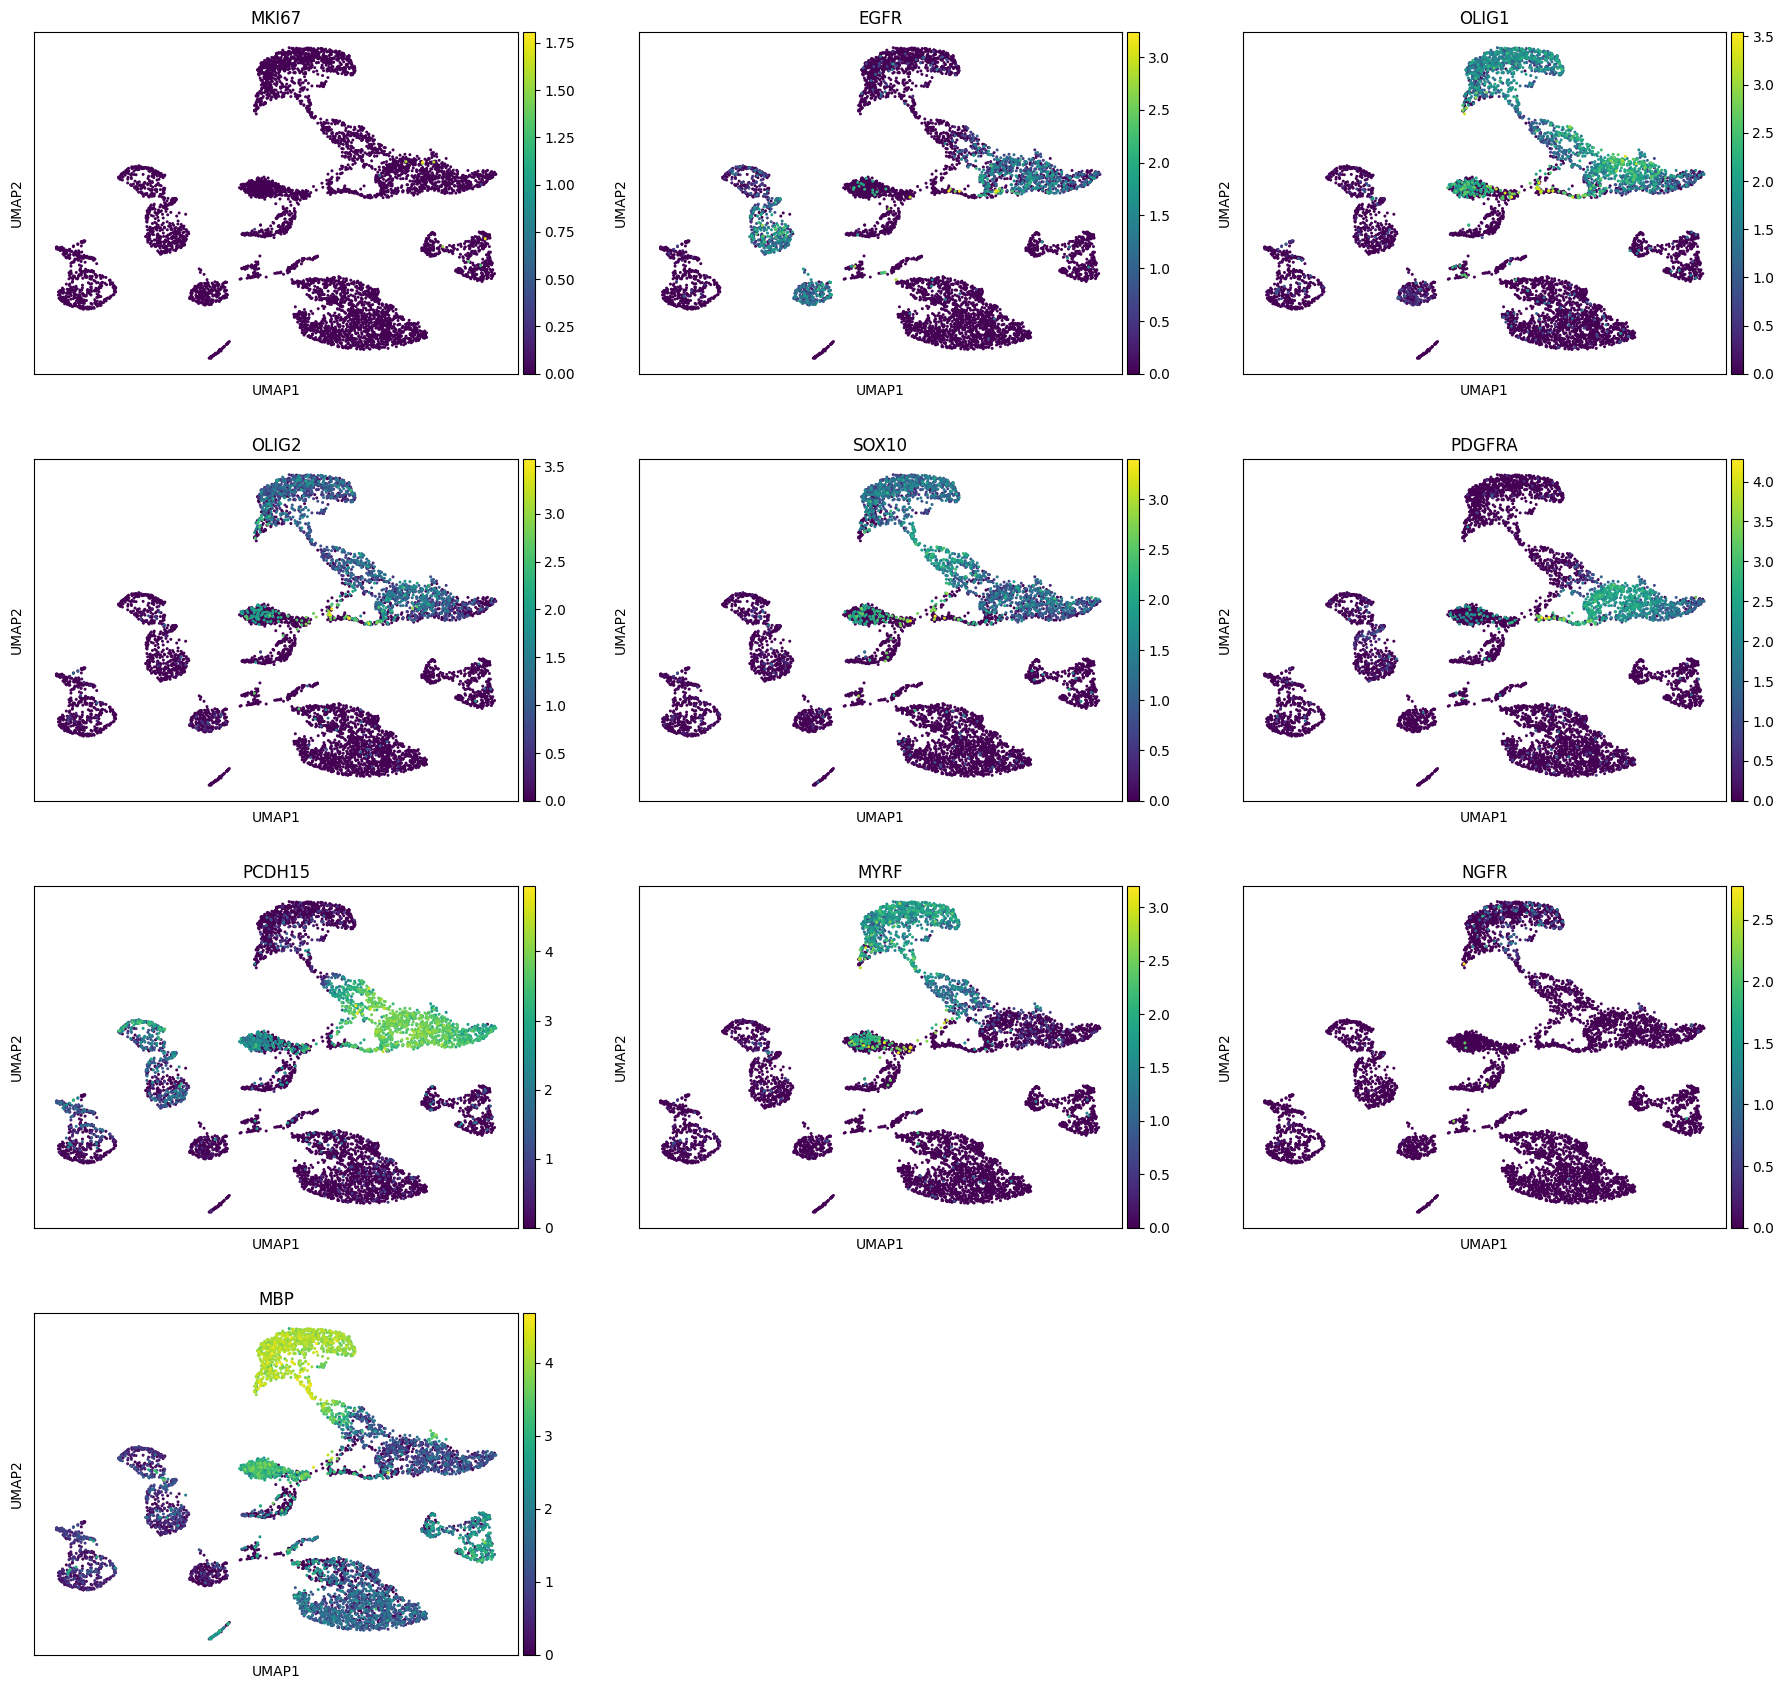

In [ ]:
# Plot of Oligodendrocytes markers
genes_to_plot = ['MKI67', 'EGFR', 'OLIG1', 'OLIG2', 'SOX10', 'PDGFRA', 'PCDH15', 'MYRF', 'NGFR', 'MBP']

"""
What are these OL markers?


"""

sc.pl.umap(data, color=genes_to_plot, use_raw=True,
                sort_order=True, ncols=3)

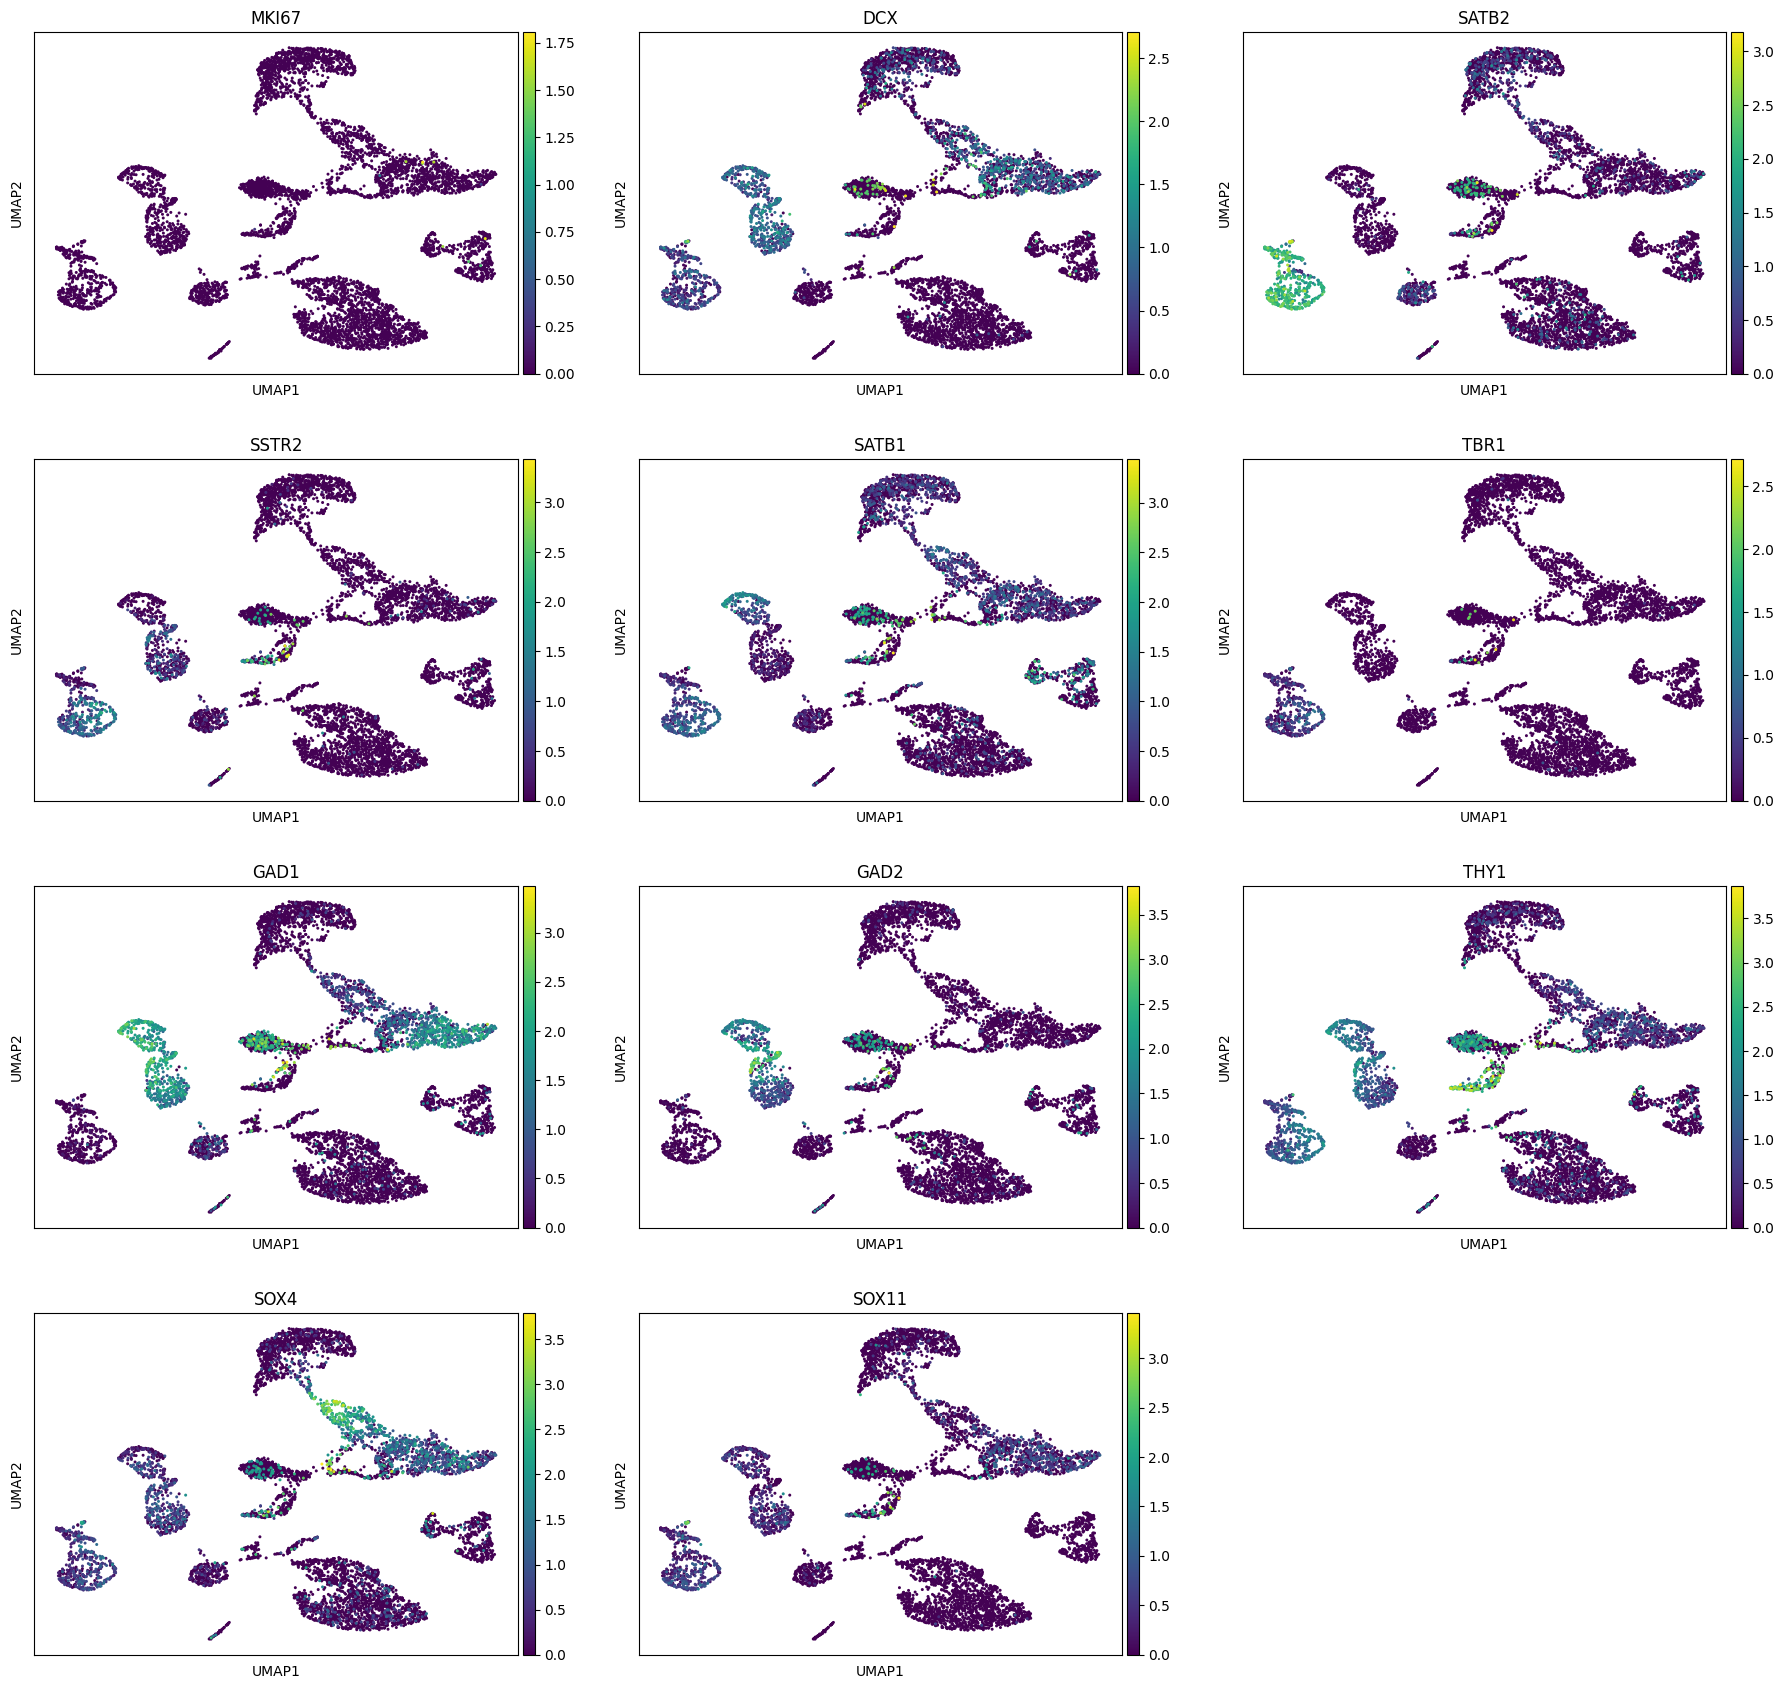

In [12]:
# Plot of Neuron markers
genes_to_plot = ['MKI67', 'DCX', 'SATB2', 'SSTR2', 'SATB1', 'TBR1', 'GAD1', 'GAD2', 'THY1', 'SOX4', 'SOX11']

"""
What are these neuron markers?


"""

sc.pl.umap(data, color=genes_to_plot, use_raw=True,
                sort_order=True, ncols=3)

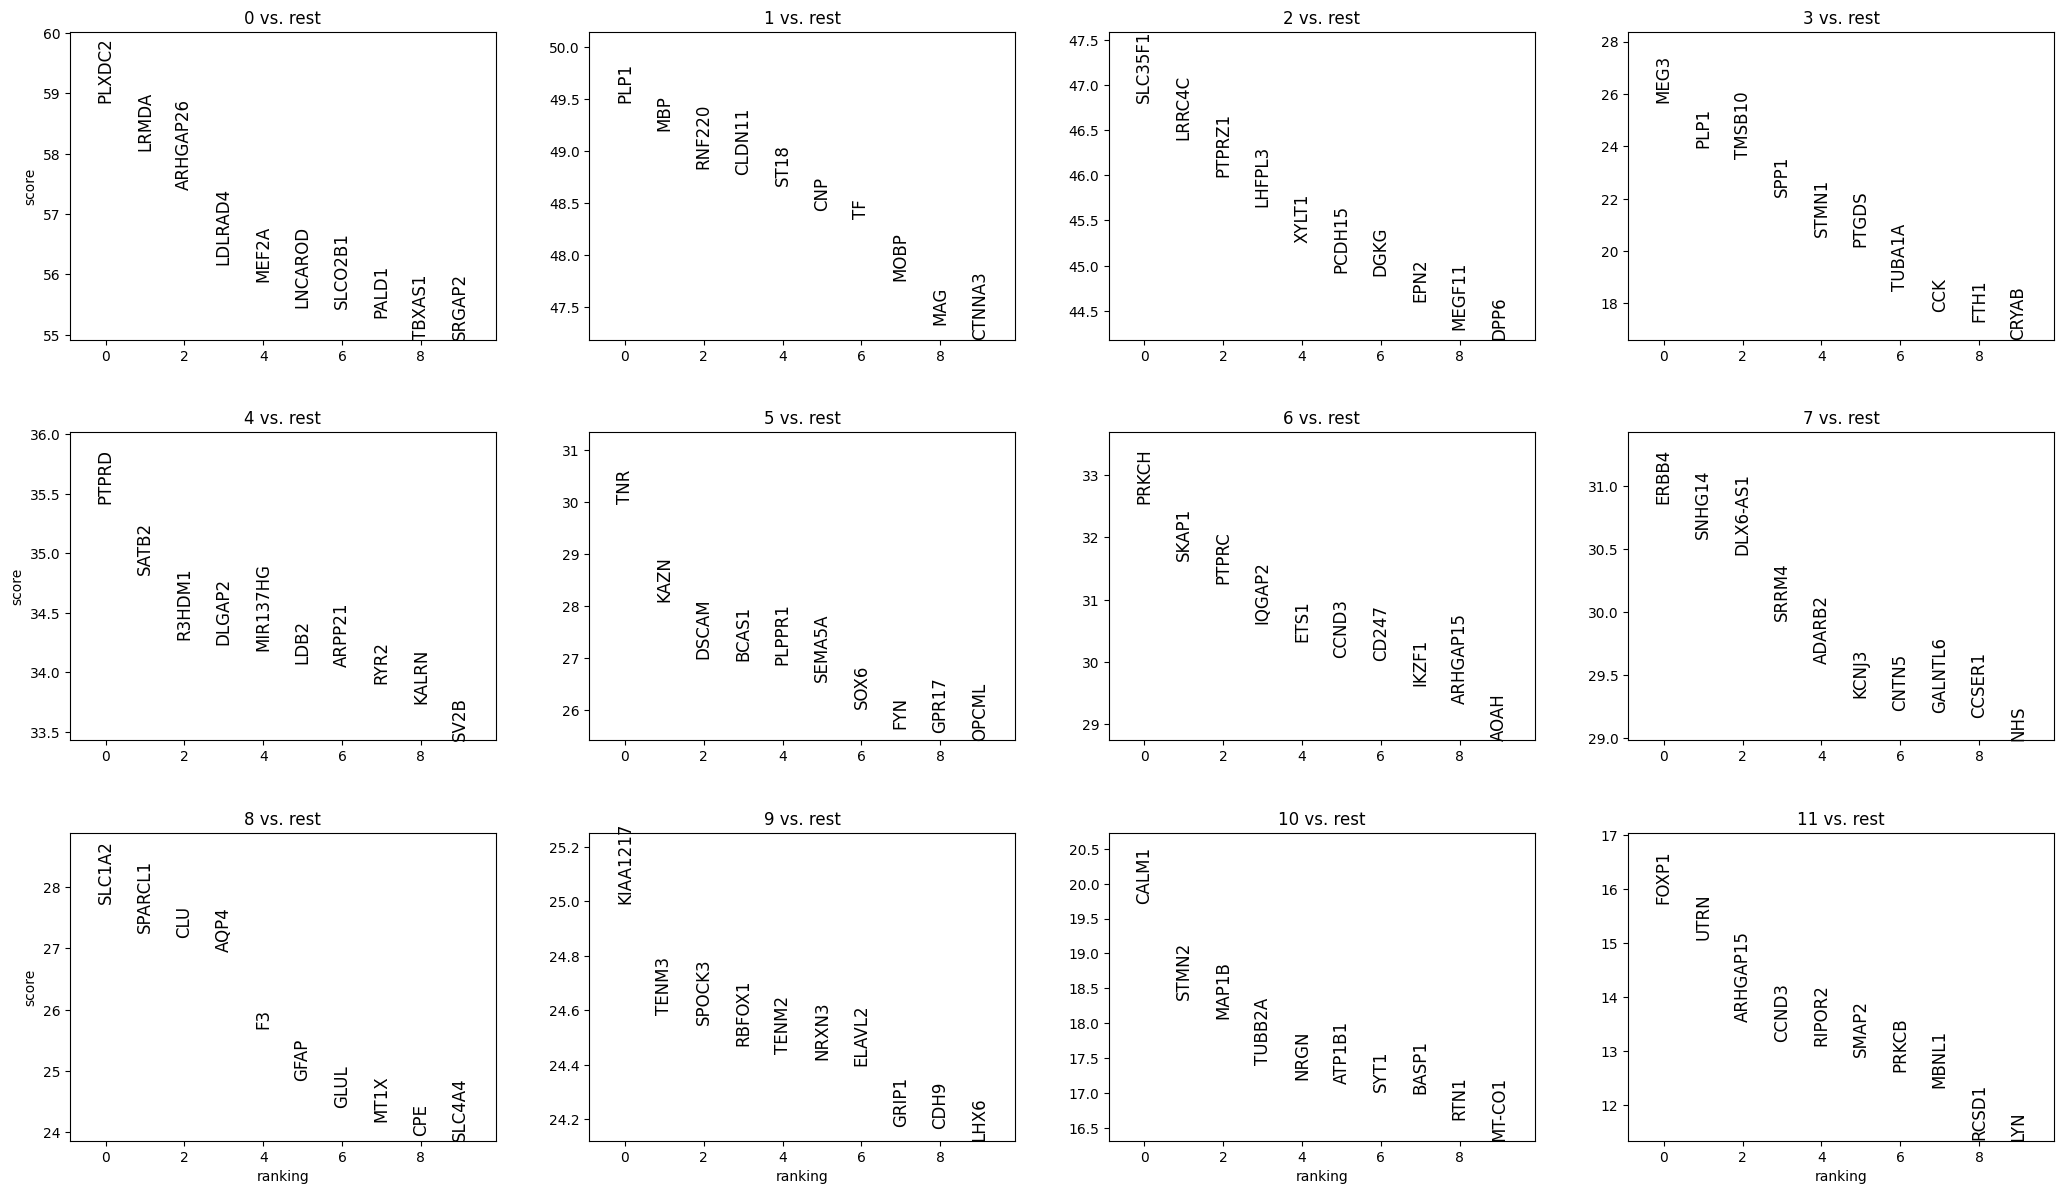

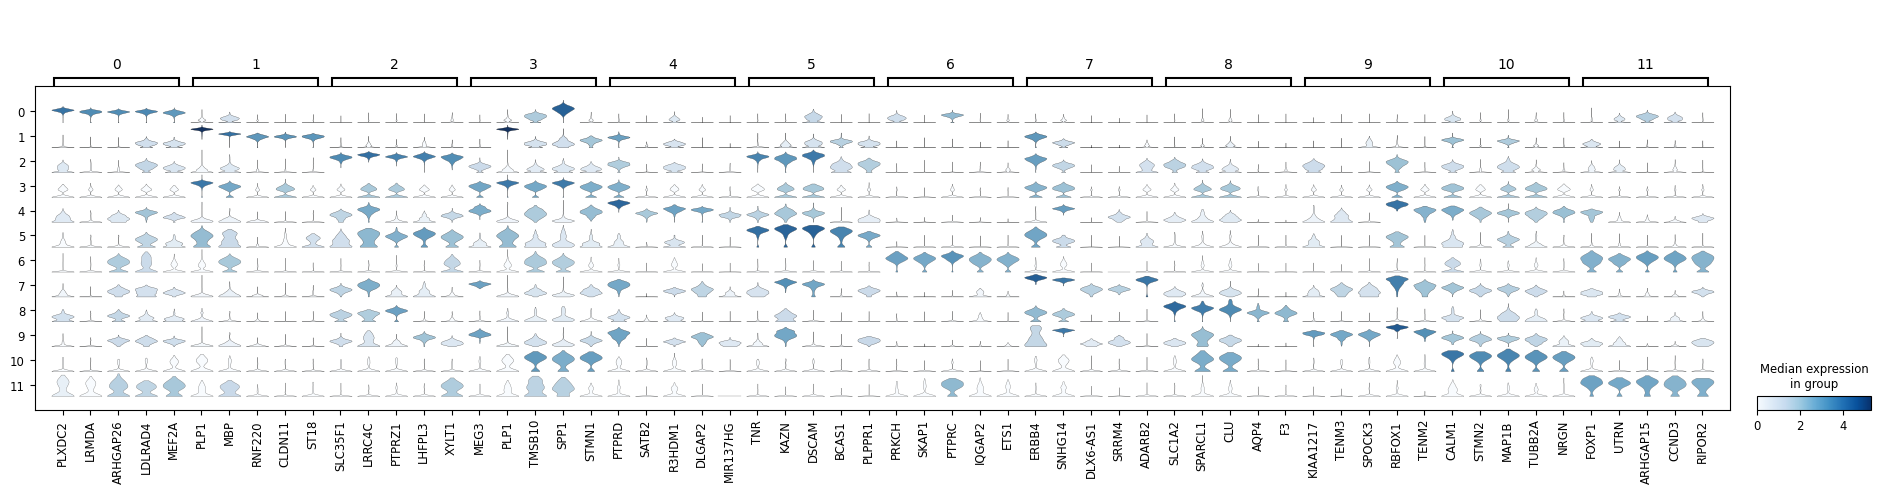

In [13]:
# Identification of differentially expressed genes between clusters 
sc.tl.rank_genes_groups(data, 'leiden', method='wilcoxon',
                       n_genes=25)

sc.pl.rank_genes_groups(data, n_genes=10, sharey=False,
                        fontsize=12)

pd.DataFrame(data.uns['rank_genes_groups']['names']).head(5)

sc.pl.rank_genes_groups_stacked_violin(data,
                              n_genes=5, dendrogram=False)